In [405]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import yfinance as yf

# Auxiliary Functions

In [ ]:
def computeBeta(df_portfolio_returns, df_ibov):

    first_valid_idx = returns.iloc[:, 1:241].apply(lambda x: df_portfolio_returns.iloc[:, 1:241].columns.get_loc(x.first_valid_index()), axis=1).values
    last_valid_idx = returns.iloc[:, 1:241].apply(lambda x: df_portfolio_returns.iloc[:, 1:241].columns.get_loc(x.last_valid_index()), axis=1).values


    betas = []
    # Get Beta for each row
    for i, row in df_portfolio_returns.iterrows():
        corr_e_m = np.corrcoef(ma.masked_invalid(row[first_valid_idx[i]+1:last_valid_idx[i]+1].astype(float)), ma.masked_invalid(df_ibov[first_valid_idx[i]:last_valid_idx[i]]))[0][1]
        std_e = np.std(returns.iloc[i, first_valid_idx[i]:last_valid_idx[i]].astype(float))
        std_m = np.std(df_ibov[first_valid_idx[i]:last_valid_idx[i]])
        beta = corr_e_m*std_e/std_m
        betas.append(beta)
    return betas

# Data Cleaning and Feature Engineering

In [406]:
df = pd.read_csv('investment_fund_data_10M.csv').iloc[:,1:]
class_fund = pd.read_csv('fundo_classe.csv', sep = ';', encoding = 'ISO-8859-1')
selic = pd.read_csv("selic_historica.csv")
ibov = yf.download("^BVSP", start="2002-11-30", end="2022-12-3")

[*********************100%***********************]  1 of 1 completed


In [407]:
# Get percent changes in IBOV
ibov.reset_index(inplace = True)
ibov['year_month'] = ibov['Date'].dt.to_period('M')
ibov = ibov.groupby('year_month')['Open'].mean()
# Get month/month percent dufference
ibov = ibov.pct_change(periods=1)

In [408]:
# Filter for values between Dec/2002 to Dec/2022
df = df.drop(['2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08',
             '2002-09', '2002-10', '2002-11'], axis = 1) # '2002-01', 

In [409]:
# Keep only funds that did not change their classification and that are fundos de ação
class_fund.drop_duplicates('CNPJ_FUNDO', keep = False, inplace = True)
class_fund = class_fund[class_fund.CLASSE == 'Fundo de Ações']

In [410]:
# Merge with investment_fund_data
fundos = df.merge(class_fund[['CNPJ_FUNDO']], on = 'CNPJ_FUNDO')
fundos.set_index('CNPJ_FUNDO',  inplace = True)

In [411]:
# Correct weird effect where some funds have results for 12-2002 but not again for some time
fundos.loc[fundos['2003-01'].isna(), '2002-12'] = np.NaN

In [412]:
# Find the first and last column with a non-null value for each row
fundos['first_value'] = pd.to_datetime(fundos.notnull().idxmax(axis=1))
fundos['last_value'] = pd.to_datetime(fundos.notnull().idxmin(axis=1))

# Get first and last quotes
fundos['first_quote'] = fundos.iloc[:,:-2].apply(lambda x: x[x > 0].at[x[x > 0].first_valid_index()], axis=1)
fundos['last_quote'] = fundos.iloc[:,:-3].apply(lambda x: x[x > 0].at[x[x > 0].last_valid_index()], axis=1)
fundos["absolute_change"] = fundos['last_quote']/fundos['first_quote'] - 1


# Find the last column with a non-null value for each row, starting from the right
fundos['last_value_from_right'] = fundos.iloc[:, :241].loc[:, ::-1].notnull().idxmin(axis=1)
fundos['first_value_from_right'] = fundos.iloc[:, :241].loc[:, ::-1].notnull().idxmax(axis=1)

# Convert the first_value and last_value columns to datetime
#fundos['first_value'] = pd.to_datetime(fundos['first_value'])
#fundos['last_value'] = pd.to_datetime(fundos['last_value'])

# Replace the last_value for rows where it is equal to 2002-12-01 with the last_value_from_right
fundos.loc[fundos['last_value'] == pd.to_datetime('2002-12-01'), 'last_value'] = fundos['first_value_from_right']
fundos['last_value'] = pd.to_datetime(fundos['last_value'])

# Drop the last_value_from_right column
fundos.drop(['last_value_from_right', 'first_value_from_right'], axis=1, inplace=True)

In [414]:
# Filter for funds that existed prior to 2012-12-01 and existed for longer than one year
#fundos = fundos[fundos.first_value <= pd.to_datetime('2012-12-01')] - should I remove these guys?
fundos['months_existing'] = ((fundos['last_value'] - fundos['first_value'])/np.timedelta64(1, 'M')).astype(int)
fundos = fundos[fundos['months_existing'] > 12]

In [415]:
# Compute average Risk Free Rate and Market Rate while the fund existed
fundos = fundos.reset_index()
selic['Date'] = pd.to_datetime(selic['Date'])
selic.set_index('Date', inplace = True)
selic_averages = []
ibov_averages = []
for index, row in fundos.iterrows():
    start_date = row['first_value']
    end_date = row['last_value']
    average_selic = selic.loc[start_date:end_date].mean().Rate
    selic_averages.append(average_selic)
    average_ibov = pd.DataFrame(ibov).loc[start_date:end_date].mean().Open
    ibov_averages.append(average_ibov)
fundos["mean_monthly_selic"] = selic_averages
fundos["mean_monthly_ibov"] = ibov_averages


In [416]:
# Compute Mean, Std and Sharpe of each fund
fundos = fundos.set_index('CNPJ_FUNDO')
returns = fundos.iloc[:, :241]/fundos.iloc[:, :241].shift(1, axis = 1)-1 
returns.replace([np.inf, -np.inf], np.NaN, inplace=True)
returns = returns.clip(upper=2) # Caping because of data entry errors
returns['mean_monthly_return'] = returns.mean(axis = 1, skipna = True, numeric_only = True)
returns['std_monthly_return'] = returns.std(axis = 1, skipna = True)
#returns['sharpe'] = returns['mean_return']/returns['std_return']
fundos.reset_index(inplace = True)
returns.reset_index(inplace = True)
fundos = fundos.merge(returns[['CNPJ_FUNDO', 'mean_monthly_return', 'std_monthly_return']], on = 'CNPJ_FUNDO') # 2 funds that had no change over time drop out
fundos['sharpe'] = (fundos['mean_monthly_return'] - fundos['mean_monthly_selic'])/fundos['std_monthly_return'] # check this

In [420]:
returns['beta'] = computeBeta(returns, ibov)

In [421]:
# Investigate why nulls intervalues happen later
returns = returns[~returns.beta.isna()]

In [422]:
# Merge Returns dataframe to fundos and compute alpha for each equity fund
fundos = fundos.merge(returns[['CNPJ_FUNDO', 'beta']], on = 'CNPJ_FUNDO')


In [423]:
fundos['alpha'] = fundos['mean_monthly_return'] - fundos['mean_monthly_selic'] - fundos['beta']*(fundos['mean_monthly_ibov'] - fundos['mean_monthly_selic'])

# Survival Analysis

## Survivor Function

In [550]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [551]:
fundos['Exited'] = fundos['last_value'] < pd.to_datetime('2022-11-01')

In [552]:
kmf.fit(fundos["months_existing"], fundos['Exited'], label="Kaplan-Meier Estimate")

<lifelines.KaplanMeierFitter:"Kaplan-Meier Estimate", fitted with 3153 total observations, 2157 right-censored observations>

Text(0.5, 0, "Fund's Age (months)")

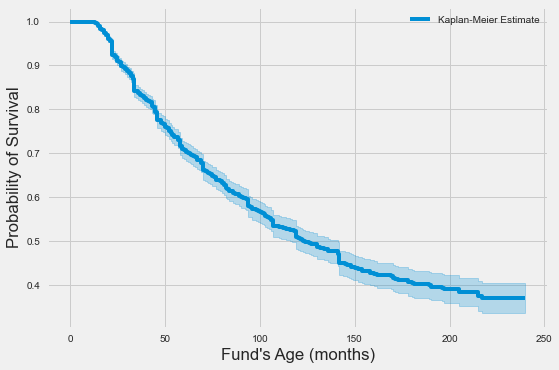

In [553]:
kmf.plot()
plt.ylabel("Probability of Survival")
plt.xlabel("Fund's Age (months)")

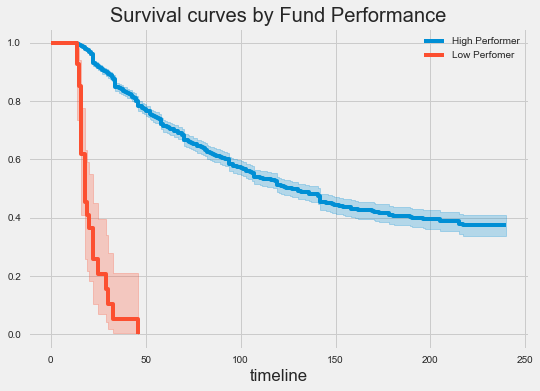

In [554]:
fundos["performance_group"] = pd.cut(fundos["mean_monthly_return"], bins = 2, labels = ["Low Perfomer", "High Performer"])
T = fundos['months_existing']
E = fundos['Exited']
ax = plt.subplot(111)
for perf_group in fundos['performance_group'].unique():
    
    flag = fundos['performance_group'] == perf_group
    
    kmf.fit(T[flag], event_observed=E[flag], label=perf_group)
    kmf.plot(ax=ax)

plt.title("Survival curves by Fund Performance");

In [57]:
fundos['alpha'].head(20)

0     0.000144
1    -0.002881
2    -0.024581
3      0.00277
4     0.003071
5    -0.105755
6    -0.018469
7     0.000861
8    -0.002299
9     0.003026
10    0.004817
11   -0.000903
12   -0.000085
13    0.005137
14    0.001044
15    0.002042
16          --
17    0.002627
18    0.004715
19    0.001236
Name: alpha, dtype: object

In [43]:
kmf.fit(fundos["alpha"], fundos['Exited'], label="Kaplan-Meier Estimate")
kmf.plot()
plt.ylabel("Probability of Survival")
plt.xlabel("Fund's Age (months)")

C:\Users\mathe\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\mathe\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1189: UserWarning: Warning: converting a masked element to nan.
  infs = np.isinf(df_or_array.astype(float))


ValueError: Values must be numeric: no strings, datetimes, objects, etc.

## Hazard Function

In [919]:
from lifelines import NelsonAalenFitter

<AxesSubplot:xlabel='timeline'>

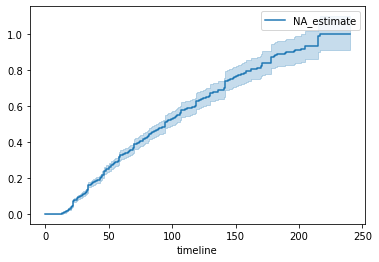

In [920]:
naf = NelsonAalenFitter()
naf.fit(fundos["months_existing"], event_observed=fundos['Exited'])

naf.plot()

## Correlation between Months of Existence and return

In [ ]:
# Correlation between months_existing and sharpe
fundos['bin_months_existing'] = pd.cut(fundos['months_existing'], 
                                       bins = [0, 50, 100, 150, 200, 250],
                                       labels = ['50 or less', '50 to 100', '100 to 150', '150 to 200', '200 to 250'])

Text(0.5, 0, 'Months of Existence')

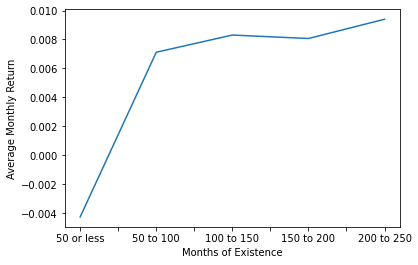

In [921]:
fundos.groupby('bin_months_existing')['mean_monthly_return'].mean().plot()
plt.ylabel('Average Monthly Return')
plt.xlabel('Months of Existence')

# Normality Tests

## Visual Comparison

In [922]:
mean = fundos['sharpe'].mean()  # mudar pra ibov
std = fundos['sharpe'].std() # mudar pra ibov
x = np.random.normal(mean, std, 1000)

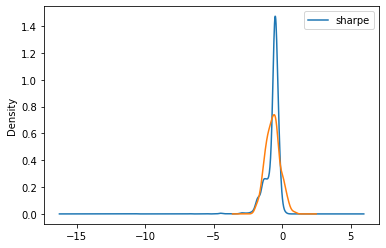

In [923]:
# Distribution of Sharpe
fundos['sharpe'].plot.kde(legend = 'Empirical Distribution')
pd.Series(x).plot.kde(legend = 'Normal Distribution')
#plt.hist(x, bins = 10000)
plt.legend()

## QQ Plot

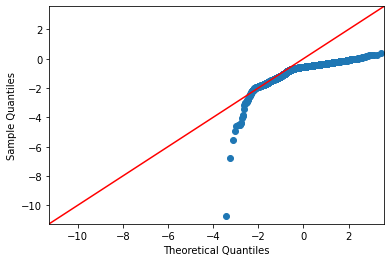

In [924]:
import math
from scipy.stats import lognorm
import statsmodels.api as sm

#make this example reproducible
np.random.seed(1)

#generate dataset that contains 1000 log-normal distributed values
#lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(fundos['sharpe'], line='45')

plt.show()

## Shapiro-Wilk Test

In [925]:
from scipy.stats import shapiro 

In [926]:
shapiro(fundos['sharpe'])

ShapiroResult(statistic=0.7388767004013062, pvalue=0.0)

## KS Test

In [927]:
from scipy.stats import kstest

In [928]:
kstest(fundos['sharpe'], 'norm')

KstestResult(statistic=0.5258648717511707, pvalue=0.0)

In [929]:
# Are all funds in investment_fund_data in fundo_classe? No. 1264 CNPJs no investment_fund nao encontrados no fundo_classe. 
# Removed 6,011 funds because they either are not in fundo_classe or changed their classe over time
# 3915 funds were removed because they were less than 10 years old

In [930]:
# Why do some have NaNs and then have data again? Check funds that are inactive and remove them at that date
# Plot funds that are dieing out (check that these indeed have lower performance)
# Plot distribution of Sharpe, Return and Volatility
# Normality test

# Portfolio Simulation

In [217]:
selected_stocks = "BBDC3.SA ELET3.SA PETR3.SA VALE3.SA EMBR3.SA GGBR3.SA ITUB3.SA ABEV3.SA CMIG3.SA USIM3.SA ITSA3.SA OIBR3.SA VIVT3.SA"

In [280]:
# Retrieve data
stocks = yf.download(selected_stocks, start="2002-11-29", end="2022-12-01") # 100 largest stocks in 2023

# Normalize data
stocks = stocks.div(stocks.iloc[0])

# Fill NaNs for PETR3.SA with immediate previous value
stocks = stocks.ffill()

# Fix first date to avoid merge issues
stocks = stocks.reset_index().replace({'2002-11-29':'2002-12-01'})#.set_index('Date')

# Change to monthly aggregation level
stocks = stocks[['Date', 'Adj Close']]
stocks['month_year'] = stocks['Date'].dt.to_period('M')
stocks['month_year'] = pd.to_datetime(stocks['month_year'].astype(str))
stocks = stocks.drop('Date', axis = 1)
stocks = pd.DataFrame(stocks.groupby('month_year').mean())
stocks.columns = stocks.columns.droplevel(0)
stocks.reset_index(inplace = True)

[*********************100%***********************]  13 of 13 completed


In [488]:
def samplePortfolioWeights(n_stocks, n_rows):
    """
    """
    sampled_weights_df = pd.DataFrame(np.random.dirichlet(np.ones(n_stocks),size=n_rows))
    sampled_weights_df.columns = ['ABEV3.SA', 'BBDC3.SA', 'CMIG3.SA', 'ELET3.SA',
                                   'EMBR3.SA', 'GGBR3.SA', 'ITSA3.SA', 'ITUB3.SA',
                                   'OIBR3.SA', 'PETR3.SA', 'USIM3.SA', 'VALE3.SA',
                                   'VIVT3.SA']
    return sampled_weights_df

def iterateRows(funds_df, ibov_series, stocks_df):
    """
    """
    # Fix ibov_df
    ibov_df = pd.DataFrame(ibov_series).reset_index()
    ibov_df['month_year'] = pd.to_datetime(ibov_df['month_year'].astype(str))
    
    p_vals = []
    for index, row in funds_df.iterrows():
        p_val = computePValue(row, ibov_df, stocks_df)
        p_vals.append(p_val)
    #funds_df.iloc[:10]['p_vals'] = p_vals
    return p_vals


def computePValue(row_df, ibov_df, stocks_df):
    """
    """
    first_date = row_df['first_value']
    mean_monthly_selic = row_df['mean_monthly_selic'] 
    mean_monthly_ibov = row_df['mean_monthly_ibov']
    alpha = row_df['alpha']
    
    sampled_weights_df = samplePortfolioWeights(13, 1000)
    sampled_weights_df = computeBeta(sampled_weights_df, first_date, ibov_df, stocks_df)
    # Compute alpha distribution
    sampled_weights_df['mean_monthly_selic'] = mean_monthly_selic
    sampled_weights_df['mean_monthly_ibov'] = mean_monthly_ibov
    sampled_weights_df['alpha'] = sampled_weights_df['mean_monthly_return_portfolio'] - sampled_weights_df['mean_monthly_selic'] -  sampled_weights_df['beta']*(sampled_weights_df['mean_monthly_ibov'] - sampled_weights_df['mean_monthly_selic'])
    # Compute p-value
    p_val = np.mean(alpha >= sampled_weights_df['alpha'])
    return p_val

def computeBeta(sample_weights_df, first_date, ibov_df, stocks_df):
    # Make this 
    """ """
    mean_monthly_return_portfolio_array = []
    beta_array = []
    

    std_m = np.std(ibov_df[ibov_df.month_year >= first_date]['Open'])
    for i, row in sample_weights_df.iterrows():
        # Compute r_e for each synthetic porfolio
        total_return_df = stocks_df[stocks_df.month_year >= first_date].drop('month_year', axis = 1).dot(sampled_weights_df.iloc[i:i+1,:].T)
        monthly_return_df = total_return_df/total_return_df.shift(1) - 1
        monthly_return_df.columns = ['monthly_return']
        mean_monthly_return_portfolio = monthly_return_df['monthly_return'].mean()
        corr_e_m = np.corrcoef(ma.masked_invalid(monthly_return_df[1:]['monthly_return']),ma.masked_invalid(ibov_df[ibov_df.month_year > first_date][1:]['Open']))[0][1]
        std_e = np.std(monthly_return_df['monthly_return'])
        beta = corr_e_m*std_e/std_m
        mean_monthly_return_portfolio_array.append(mean_monthly_return_portfolio)
        beta_array.append(beta)
    
    sample_weights_df['beta'] = beta_array
    sample_weights_df['mean_monthly_return_portfolio'] = mean_monthly_return_portfolio_array
    
    return sample_weights_df

# add rf and rm to the sample_weights_df and the compute alpha

'''
mult_df = pd.DataFrame()
    for col1, col2 in zip(sampled_weights_df.columns, div_df.columns):
        mult_df[col1.replace('w', 'return')] = sampled_weights_df[col1]*div_df[col2]
'''
    

"\nmult_df = pd.DataFrame()\n    for col1, col2 in zip(sampled_weights_df.columns, div_df.columns):\n        mult_df[col1.replace('w', 'return')] = sampled_weights_df[col1]*div_df[col2]\n"

In [497]:
pval_dist = iterateRows(fundos, df_ibov, stocks)

In [547]:
plt.style.use('fivethirtyeight')

Text(0, 0.5, 'Density')

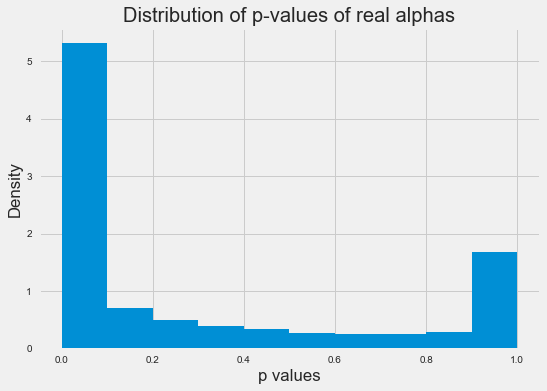

In [548]:
plt.hist(pval_dist, density = True)
plt.title("Distribution of p-values of real alphas")
plt.xlabel("p values")
plt.ylabel("Density")

# Old Code

In [1]:
'''
# Get initial and ending stock price for each of the stocks in the Ibov index 2002
tolerance = pd.Timedelta('1W')
fundos = fundos.sort_values('first_value')
fundos = pd.merge_asof(fundos, stocks["Adj Close"], left_on = 'first_value', right_on = 'Date', tolerance=tolerance).drop('Date', axis = 1)
fundos = fundos.sort_values('last_value')
fundos = pd.merge_asof(fundos, stocks["Adj Close"], left_on = 'last_value', right_on = 'Date', suffixes = ('_start', '_end'), tolerance=tolerance)
# Divide ending stock price by initial stock price
fundos = fundos.set_index('CNPJ_FUNDO')
initial_price = fundos.filter(like = 'start')
ending_price = fundos.filter(like = 'end')
division_df = pd.DataFrame()
for col1, col2 in zip(initial_price.columns, ending_price.columns):
    division_df[col1.replace("start", "div")] = ending_price[col2] / initial_price[col1]
# Remove start and end prices of stocks
fundos = fundos[fundos.columns.drop(list(fundos.filter(regex='start')))]
fundos = fundos[fundos.columns.drop(list(fundos.filter(regex='end')))]
# Add div prices
fundos = fundos.merge(division_df, left_index = True, right_index = True).drop('Date', axis = 1)
''''

SyntaxError: EOL while scanning string literal (<ipython-input-1-85e61b5e6f48>, line 20)

To Dos:
- Idea: test for folded normal
- Read more from the literature on censored data and EMH
- Review and write down all reasons why funds were excluded
- Check Sharpe ratios are correct using software

In [ ]:
Post:
    - Explain Kaplan-Meier and Nelson-Aalen
    - Explain Survivorship bias
    - Explain Sharpe Ratio and why I chose it
    - Explain idea of portfolio simulation
    - Explain multiple test correction
    - Explain why restrict to FIAs